
    Developing Neural Networks for classifying documents in 1 of 4 categories in Requirement 1
    of the Big Data Project. 
    We developed 2 models using the keras library, with the second one being less complicated than the first.
    We evaluated the perfomance on 100,000 samples from the dataset, performing k-fold validation with k=5 (at each fold 80,000 documents for training and 20,000 for validation). The rest will be the test set, constant for all folds.
    Then, we measured the accuracy of each model in all sets on a .txt file.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import np_utils
from sklearn.model_selection import KFold

In [3]:
def getSets(df, len_train, len_val, len_test):
    """
        Given 1 dataframe, this function first shuffles it and then splits it to 3 sub-dataframes corresponding to
        train, validation and test set. 
        From these dataframes, the first column is the X (input) and the second is the y (output-label).
        Returns: X and y for all sets.
    """
    df_shuffled=df.sample(frac=1).reset_index(drop=True)

    train_df = df_shuffled[:len_train]
    val_df = df_shuffled[len_train:len_train+len_val]
    test_df = df_shuffled[len_train+len_val:len_train+len_val+len_test]

    X_train = train_df.iloc[:, 0].values
    y_train = train_df.iloc[:, 1].values
    
    X_val = val_df.iloc[:, 0].values
    y_val = val_df.iloc[:, 1].values

    X_test = test_df.iloc[:, 0].values
    y_test = test_df.iloc[:, 1].values

    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
def preprocessX(X_train, X_val, X_test, numwords=75000, maxlen=512):
    """
        Tokenizes the X_train, X_val and X_test sets to tokens corresponding to words, 
        keeping only numwords words.
        Then, performs a padding of 0 so that all sequences are of same length maxlen.
    """
    tokenizer = keras.preprocessing.text.Tokenizer(num_words=numwords)
    tokenizer.fit_on_texts(X_train)

    X_train_1 = tokenizer.texts_to_sequences(X_train)
    X_val_1 = tokenizer.texts_to_sequences(X_val)
    X_test_1 = tokenizer.texts_to_sequences(X_test)

    X_train = keras.preprocessing.sequence.pad_sequences(X_train_1, padding='post', maxlen=maxlen)
    X_val = keras.preprocessing.sequence.pad_sequences(X_val_1, padding='post', maxlen=maxlen)
    X_test = keras.preprocessing.sequence.pad_sequences(X_test_1, padding='post', maxlen=maxlen)

    return X_train, X_val, X_test

In [5]:
def preprocessY(y):
    """
        Convert list of labels to one-hot representation.
        For example class 0 will correspond to [1.0, 0.0, 0.0, 0.0].
    """
    return np_utils.to_categorical(y)

In [6]:
def model1(numwords = 100000, maxlen = 512, embedding_dim = 128):
    """
        Model1 with 2 Convolution-MaxPooling-Dropout blocks.
    """

    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=numwords, 
                            output_dim=embedding_dim,
                            input_length=maxlen))

    model.add(layers.Conv1D(128, 
                            7, 
                            activation='relu',
                            padding='same'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling1D(2))

    model.add(layers.Conv1D(128, 
                            7,
                            activation='relu',
                            padding='same'))
    model.add(layers.Dropout(0.2))
   
    model.add(layers.GlobalMaxPooling1D())

    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(4, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model.summary()

    return model

In [7]:
def model2(numwords = 100000, maxlen = 512, embedding_dim = 16):
    """
        Model2 with 1 Convolution-MaxPooling-Dropout block.
    """
    
    model = keras.Sequential()
    model.add(layers.Embedding(input_dim=numwords, 
                            output_dim=embedding_dim,
                            input_length=maxlen))

    model.add(layers.Conv1D(16, 
                            7, 
                            activation='relu',
                            padding='same'))
    model.add(layers.Dropout(0.2))
   
    model.add(layers.GlobalMaxPooling1D())

    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(50, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(4, activation='softmax'))


    model.compile(optimizer=keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    model.summary()

    return model


In [8]:
def simplerun():
    """
        Performs a round of training for 10 epochs on model2. 
    """
    df = pd.read_csv(r"/home/vkalekis/projects/bigdata/dfs1/Train_Preprocessed_new_concat.csv",encoding="utf-8").fillna(' ')
    
    # Generation of preprocessed train, validation and test sets.
    len_train = 80000
    len_val = 20000
    len_test = 10000

    numwords = 100000
    maxlen = 512
    embedding_dim = 256

    X_train, y_train, X_val, y_val, X_test, y_test = getSets(df, len_train, len_val, len_test)
    X_train, X_val, X_test = preprocessX(X_train, X_val, X_test, numwords, maxlen)

    # Converting labels to one-hot.
    y_train_oh = preprocessY(y_train)
    y_val_oh = preprocessY(y_val)
    y_test_oh = preprocessY(y_test)

    # Definition and compilation of model.
    model = model2(numwords, maxlen, embedding_dim)

    # Keras callbacks.
    earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    checkpointer = keras.callbacks.ModelCheckpoint(filepath='./models/test', monitor='val_accuracy', mode='max', save_best_only=True)
    callbacks = [earlystopper, checkpointer]

    # Training.
    history = model.fit(X_train, y_train_oh,
                        epochs=10,
                        verbose=True,
                        validation_data=(X_val, y_val_oh),
                        batch_size=32,
                        callbacks = callbacks)

    # Evaluation on all sets.
    loss, accuracy = model.evaluate(X_train, y_train_oh, verbose=False)
    print(f"Acc on train set:{accuracy:.5f}")

    loss, accuracy = model.evaluate(X_val, y_val_oh, verbose=False)
    print(f"Acc on val set:{accuracy:.5f}")

    loss, accuracy = model.evaluate(X_test, y_test_oh, verbose=False)
    print(f"Acc on test set:{accuracy:.5f}")


In [9]:
def plot_history(history):
    """
        Plots accuracy and loss on train and validation on all sets during training.
    """
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='train acc')
    plt.plot(x, val_acc, 'r', label='val acc')
    plt.title('Accuracy in train and val set')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='train loss')
    plt.plot(x, val_loss, 'r', label='val loss')
    plt.title('Loss in train and val set')
    plt.legend()

In [10]:
# Read preprocessed train set.
df = pd.read_csv(r"/home/vkalekis/projects/bigdata/dfs1/Train_Preprocessed_new_concat.csv",encoding="utf-8").fillna(' ')

In [11]:
# Generation of X and y vectors for train-validation and test datasets and definition of patameters.
numwords = 25000
maxlen = 512
embedding_dim = 16


len_train_val = 100000
train_val_df = df.head(len_train_val)
test_df = df.tail(len(df)-len_train_val)

X = train_val_df.iloc[:, 0].values
y = train_val_df.iloc[:, 1].values

X_test_out = test_df.iloc[:, 0].values
y_test_out = test_df.iloc[:, 1].values

In [14]:
# K-fold Cross Validation model evaluation
# 80,000 documents as train set, 20,000 as validation.
# Trains model for 10 epochs and then evaluates on all sets, saving the results to a .txt file for further evaluation.

kfold = KFold(n_splits=5, shuffle=True)

k = 1 
for train, val in kfold.split(X, y):
    print(k)
    print(train)
    print(val)

    # Extract the specific rows from X and y vectors for train and validation datasets and preprocesses them.

    X_train = np.take(X, train)
    X_val = np.take(X, val)
    y_train = np.take(y, train)
    y_val = np.take(y, val)

    X_train, X_val, X_test = preprocessX(X_train, X_val, X_test_out, numwords, maxlen)

    y_train_oh = preprocessY(y_train)
    y_val_oh = preprocessY(y_val)
    y_test_oh = preprocessY(y_test_out)

    print(X_train.shape)
    print(y_train_oh.shape)

    # Definition of models.    
    #model = model1(numwords, maxlen, 128)
    model = model2(100000, maxlen, embedding_dim)

    # Keras callbacks.
    earlystopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
    checkpointer = keras.callbacks.ModelCheckpoint(filepath='./models/test', monitor='val_accuracy', mode='max', save_best_only=True)
    reduceLR = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=5)
    callbacks = [earlystopper, checkpointer, reduceLR]

    # Training.
    history = model.fit(X_train, y_train_oh,
                    epochs=10,
                    verbose=2,
                    validation_data=(X_val, y_val_oh),
                    batch_size=32,
                    callbacks = callbacks)

    # Evaluation on all sets.    
    model = keras.models.load_model('./models/test')
    with open(r"./resultsml.txt", "a") as f:
        loss, accuracy = model.evaluate(X_train, y_train_oh, verbose=False)
        f.write(f"Acc on train set:{accuracy:.5f}\n")
        loss, accuracy = model.evaluate(X_val, y_val_oh, verbose=False)
        f.write(f"Acc on val set:{accuracy:.5f}\n")
        loss, accuracy = model.evaluate(X_test, y_test_oh, verbose=False)
        f.write(f"Acc on test set:{accuracy:.5f}\n")
    k += 1

1
[    0     2     3 ... 99997 99998 99999]
[    1     7    11 ... 99975 99989 99992]
(80000, 512)
(80000, 4)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 512, 16)           1600000   
                                                                 
 conv1d_10 (Conv1D)          (None, 512, 16)           1808      
                                                                 
 dropout_25 (Dropout)        (None, 512, 16)           0         
                                                                 
 global_max_pooling1d_5 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 100)               1700      
                                                                 
 dropout_2

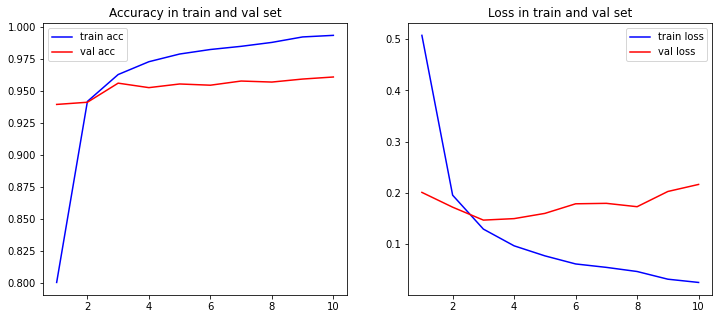

In [15]:
# Plots history of last model.
plot_history(history)